In [167]:
from google.colab import drive
drive.mount('/content/drive')

save_dir = '/content/drive/My Drive/computer_vision/HW3A/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [168]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import seaborn as sns
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [169]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

class_map = {
    3: 0,  # cat
    1: 1,  # car
    6: 2,  # frog
}

def transform_labels(l):
  if l in class_map:
    return class_map[l]
  else:
    return 3  # other

trainset.targets = [transform_labels(l) for l in trainset.targets]
testset.targets = [transform_labels(l) for l in testset.targets]

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('cat', 'car', 'frog', 'other')

Files already downloaded and verified
Files already downloaded and verified


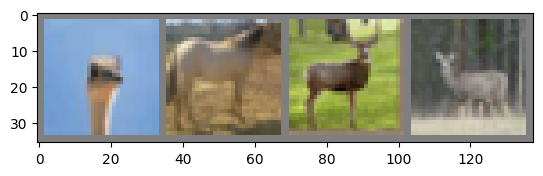

other other other other


In [170]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [171]:
class CNN1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class CNN2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=32, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(64 * 2 * 2, 120)
        self.fc2 = nn.Linear(120, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

cnn = CNN1()
cnn = cnn.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)

[1,  2000] loss: 0.999
[1,  4000] loss: 0.813
[1,  6000] loss: 0.755
[1,  8000] loss: 0.700
[1, 10000] loss: 0.663
[1, 12000] loss: 0.643
[2,  2000] loss: 0.780
[2,  4000] loss: 0.623
[2,  6000] loss: 0.602
[2,  8000] loss: 0.592
[2, 10000] loss: 0.584
[2, 12000] loss: 0.576
[3,  2000] loss: 0.678
[3,  4000] loss: 0.546
[3,  6000] loss: 0.536
[3,  8000] loss: 0.541
[3, 10000] loss: 0.549
[3, 12000] loss: 0.536
[4,  2000] loss: 0.631
[4,  4000] loss: 0.499
[4,  6000] loss: 0.503
[4,  8000] loss: 0.500
[4, 10000] loss: 0.512
[4, 12000] loss: 0.501
[5,  2000] loss: 0.602
[5,  4000] loss: 0.483
[5,  6000] loss: 0.470
[5,  8000] loss: 0.472
[5, 10000] loss: 0.454
[5, 12000] loss: 0.472
[6,  2000] loss: 0.548
[6,  4000] loss: 0.435
[6,  6000] loss: 0.443
[6,  8000] loss: 0.437
[6, 10000] loss: 0.452
[6, 12000] loss: 0.446
[7,  2000] loss: 0.513
[7,  4000] loss: 0.416
[7,  6000] loss: 0.410
[7,  8000] loss: 0.421
[7, 10000] loss: 0.426
[7, 12000] loss: 0.423
[8,  2000] loss: 0.487
[8,  4000] 

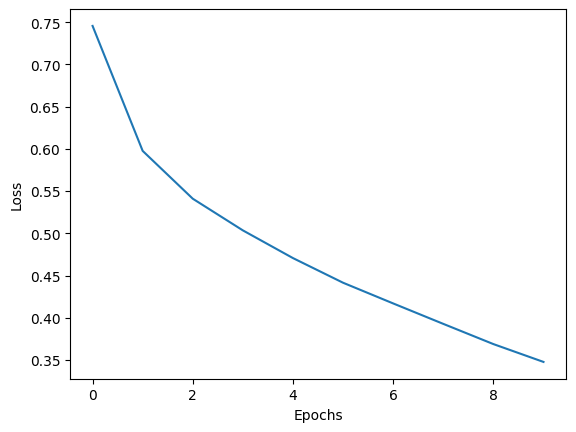

In [172]:
loss_vals = []
epochs = 10

start = time.time()
for epoch in range(epochs):
    temp_loss, count = 0.0, 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = cnn(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        count += 1
        temp_loss += loss.item()
        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

    loss_vals.append(temp_loss/count)

print('Finished Training')
print('Training time: ', time.time() - start)

plt.plot(np.arange(epochs), loss_vals)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig(save_dir + 'e4_loss.png')
plt.show()

In [173]:
correct = 0
total = 0

start = time.time()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        outputs = cnn(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the CNN: {100 * correct // total} %')
print('Testing time: ', time.time() - start)

Accuracy of the CNN: 80 %
Testing time:  8.511779308319092


Accuracy for class: cat   is 25.1 %
Accuracy for class: car   is 60.2 %
Accuracy for class: frog  is 60.5 %
Accuracy for class: other is 94.5 %
[0, 3, 3, 3, 2, 2, 1, 2, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 2, 3, 2, 3, 3, 0, 3, 3, 2, 3, 3, 3, 0, 3, 3, 3, 3, 3, 2, 3, 0, 2, 0, 2, 3, 1, 3, 0, 3, 3, 2, 3, 3, 3, 3, 3, 0, 0, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 2, 3, 2, 2, 3, 3, 3, 3, 3, 2, 0, 1, 1, 0, 2, 3, 3, 3, 3, 2, 3, 1, 0, 3, 3, 3, 3, 3, 0, 1, 3, 3, 3, 3, 0, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 2, 3, 2, 0, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 1, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 0, 3, 2, 0, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 0, 3, 2, 3, 3, 2, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3, 0, 1, 3, 3, 3, 3, 0, 3, 3, 3, 3, 0, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 2, 0, 3, 3, 3, 0, 3, 0, 3, 3, 2, 1, 3, 

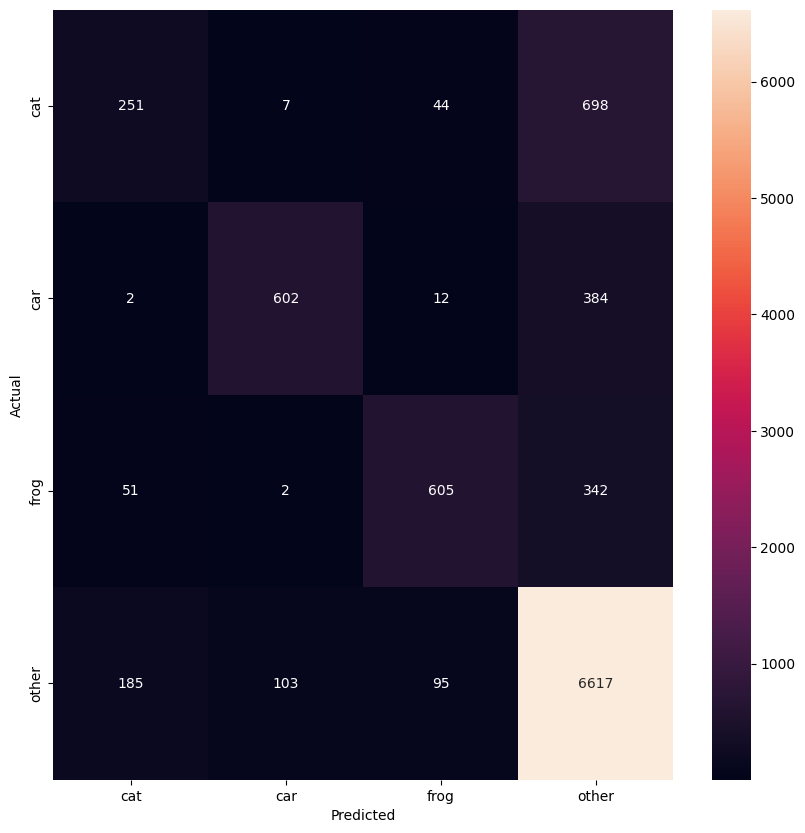

[array(3), array(3), array(3), array(3), array(3)]


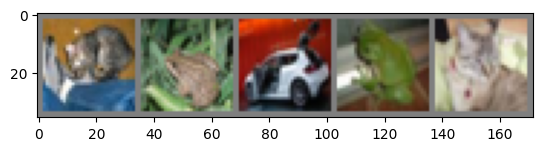

In [174]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

final_preds = []
final_labels = []
wrong_images = []
wrong_preds = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        outputs = cnn(images)
        _, predictions = torch.max(outputs, 1)

        final_preds.extend(predictions.cpu().numpy())
        final_labels.extend(labels.cpu().numpy())

        index = 0
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            else:
                wrong_images.append(images[index])
                wrong_preds.append(prediction.cpu().numpy())
            index += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

print(final_labels)
print(final_preds)

cm = confusion_matrix(final_labels, final_preds)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig(save_dir + 'e4_confusion.png')
plt.show()

print(wrong_preds[:5])
img = torchvision.utils.make_grid(wrong_images[:5])
img = img / 2 + 0.5
npimg = img.cpu().numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.savefig(save_dir + 'e4_wrong.png')
plt.show()